<a href="https://colab.research.google.com/github/d-nct/cc1-projeto2/blob/main/Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Equações diferenciais

Uma equação diferencial, de forma bastante abstrata, é dada por
$$ \begin{cases}
    y'(t)  & = F(t, y(t)) \\
    y(t_0) & = y_0.
\end{cases} $$
Uma solução é **uma função** $y(t)$ satisfazendo tanto a _condição inicial_ $y(t_0) = y_0$
quanto a _dinâmica_ $y'(t) = F(t, y(t))$.

Por questões práticas, também é comum dar um _intervalo de solução_, ou seja,
pedir que $y$ seja definida (pelo menos) num intervalo $[a,b]$ onde $t_0 \in [a,b]$.
Aqui, vamos usar $a = t_0$,
pensando "fisicamente" que a equação diferencial modela
a evolução de alguma quantidade $y$ que conhecemos agora ($t_0$)
e que queremos saber o quanto restará num momento futuro ($t_f = b$).

## Parte 1: O método de Euler

Continuando nesta linha, é razoável discretizar o problema da seguinte forma:

1. Definimos uma sequência de pontos $a = t_0 < t_1 < t_2 < \cdots < t_n = t_f = b$ no intervalo $[a,b]$.
2. Como $f$ é derivável, temos a aproximação $y(t_{i+1}) \sim y(t_i) + (t_{i+1} - t_i)y'(t_i)$.
3. A equação diferencial permide calcular $y'(t_i) = F(t_i, y(t_i))$.
4. Isso define (recursivamente) uma sequência de aproximações $y_i$ para $y(t_i)$ pela fórmula
$$ y_{i+1} = y_i + (t_{i+1} - t_i) F(t_i, y_i).$$

A sequência mais simples de ser usada é, claro, a de $n+1$ pontos igualmente espaçados no intervalo $[a,b]$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Implemente o método de Euler

Escreva a função `euler` que divide o intervalo $[t_0, t_f]$ em `nsteps` intervalos de mesmo comprimento,
e retorna
- as `nsteps+1` extremidades `t_i`,
- as `nsteps+1` aproximações `y_i` de $y$ nestes pontos.

Dica: use `append` para construir os valores de `y_i`, mas retorne um `np.array()` para simplificar as contas.

In [ ]:
def euler(F, t0, tf, y0, nsteps=100):
    ts = np.linspace(t0, tf, num = nsteps+1)
    ys = [y0]
    ycurr = y0
    tcurr = t0
    for tnext in ts[1:]:
        ynext = ycurr + F(tcurr, ycurr)*(tnext - tcurr)
        tcurr = tnext
        ycurr = ynext
        ys.append(ynext)
    return ts, np.array(ys)

Resolvendo uma EDO simples: $f' = f$.

In [ ]:
def F1(t,y):
    return y

t_100, y_100 = euler(F1, 0, 1, 1)
assert len(t_100) == 101
assert t_100[0] == 0
assert t_100[-1] == 1

In [ ]:
t_100, y_100 = euler(F1, 0, 1, 1)
assert len(y_100) == 101
assert y_100[0] == 1
assert( abs(y_100[-1] - 2.704813829421526) < 5e-15 )

O que é melhor é que o método de Euler permite resolver equações diferenciais bastante (arbitrariamente!) complicadas:

In [ ]:
def F_dificil(t, y):
    return t*np.sin(y) - t**2*np.cos(y)

_, y_dificil = euler(F_dificil, 0, 2, 1, nsteps=100)
assert( abs(y_dificil[-1] - 3.553673725510754) < 5e-15 )

### 2. Qualidade da aproximação

Agora, faça um gráfico da solução numérica com mil pontos $f_{1000}$ para $f' = f$,
e da solução exata $f(t) = e^t$ no intervalo $[0,1]$.
Faça também um gráfico da diferença entre estas soluções.

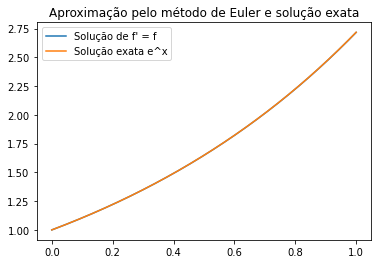

In [ ]:
xs, ys = euler(F1, 0, 1, 1, 1000)
plt.plot(xs, ys, label = "Solução de f' = f")
plt.plot(xs, np.exp(xs), label = "Solução exata e^x")
ax = plt.gca()
ax.set_title("Aproximação pelo método de Euler e solução exata")
plt.legend()
plt.show()

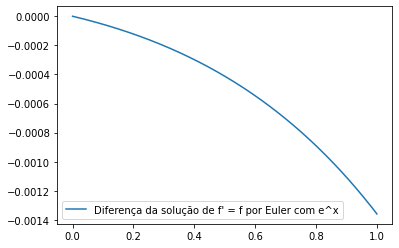

In [ ]:
xs, ys = euler(F1, 0, 1, 1, 999)
plt.plot(xs, ys - np.exp(xs), label = "Diferença da solução de f' = f por Euler com e^x")
ax = plt.gca()
plt.legend()
plt.show()

Faça o gráfico agora do erro **relativo**.

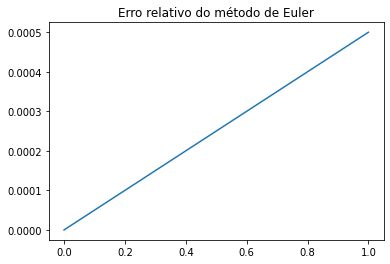

In [ ]:
xs, ys = euler(F1, 0, 1, 1, 999)

errorel = []

for i in range(1000):
    errorel.append(abs(ys[i] - np.exp(xs[i]))/np.exp(xs[i]))
plt.plot(xs, errorel)
ax = plt.gca()
ax.set_title("Erro relativo do método de Euler")
plt.show()

In [ ]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1

In [ ]:
xdata = ax.lines[0].get_xdata()
assert min(xdata) == 0.0
assert max(xdata) == 1.0

ydata = ax.lines[0].get_ydata()
assert min(ydata) > -0.001
assert max(ydata) <  0.001

In [ ]:
ax = None

### 3. Medindo erros

Suponha que conhecemos a solução exata da EDO, que chamaremos aqui de $g(t)$ para evitar confundir com $y_i$.
Mesmo que em muitos casos seja bastante razoável usar o "erro final" $g(t_n) - y_n$,
onde $g$ é a solução exata e $y_n$ a aproximação,
vamos nos concentrar no "erro total".
E, para ficar relativamente simples, vamos usar a **média dos valores absolutos das diferenças** entre $g(t_j)$ e $y_j$.
Usamos a média, e não a soma, porque ao variar o número de passos esta quantidade se mantém homogênea.

In [ ]:
def erro(g, ys, ts):
    """ Calcula o erro entre os valores de ys e g(ts).  ys e ts  devem ser vetores numpy, e  g uma função. """
    somaerros = 0
    for i in range(len(ts)):
        somaerros += abs(g(ts[i]) - ys[i])
    errofinal = somaerros/(len(ts))
    return errofinal

Como o erro total diminui ao aumentar o número de passos efetuados?
Faça um gráfico.

CPU times: user 807 ms, sys: 9.64 ms, total: 816 ms
Wall time: 822 ms


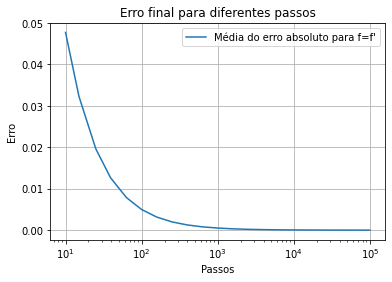

In [ ]:
%%time
ns = np.logspace(1,5,num=21, dtype=int)

erros = []
for i in range(len(ns)):
    ts, ys = euler(F1,0,1,1,ns[i])
    erros.append(erro(np.exp, ys, ts))

plt.plot(ns, erros, label = "Média do erro absoluto para f=f'")
plt.legend()
plt.xlabel("Passos")
plt.ylabel("Erro")
ax = plt.gca()
ax.set_title("Erro final para diferentes passos")
ax.set_xscale('log')
#ax.set_yscale('log') sugeriria deixar assim porque evidencia melhor a relação entre os eixos x e y (mas aí teria que alterar um pouco os comentários na celula abaixo)
plt.grid();

In [ ]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 1

ydata = ax.lines[0].get_ydata()
assert 1e-6 < min(ydata) < 1e-4
assert 1e-2 < max(ydata) < 1e-1

E comente o resultado.

Como já se poderia esperar, o erro decresce com o aumento do número de passos. É esperado, visto que um maior número de passos diminui a propagação de erro inerente ao método. O gráfico, todavia, evidencia outra coisa, não tão imediatamente esperável: que esse decrescimento acontece de forma exponencial.

### 4. Sistemas de Equações

Se você usar funções "vetorizadas" para `F`,
o seu método de Euler é capaz de resolver (aproximar) até _sistemas_ de equações diferenciais.

Por exemplo, o sistema
$$ \begin{align}
v_0' & =  v_1 \\
v_1' & = -v_0
\end{align} $$
que é equivalente à equação diferencial trigonométrica básica $y'' = -y$,
pode ser simulado assim:

In [42]:
def F2(t, v):
    return np.array([v[1],-v[0]])

ans = np.array([-1.0505597866729235, -0.0010851561020816455])
ts, vs = euler(F2, 0, np.pi, np.array([1.0,0.0]), nsteps=100)

print(abs(vs[-1]/ans - 1))

assert( all(abs(vs[-1]/ans - 1) < 1e-15) )

[4.44089210e-16 4.73177053e-13]


AssertionError: ignored

Dependendo de como você tenha implementado `euler()`, os valores de `vs` serão todos iguais,
pois você terá construído uma lista com `nsteps+1` vezes o mesmo `array`.
Para corrigir isso, modifique sua função `euler` para criar uma cópia de cada valor de $f_i$ antes de incluir na lista.

In [38]:
def euler(F, t0, tf, y0, nsteps=100):
    ts, ys = np.linspace(t0, tf, num=nsteps+1), [y0]
    tcurr,  ycurr = t0, y0
    for tnext in ts[1:]:
        ynext = ycurr + F(tcurr, ycurr)*(tnext - tcurr)
        tcurr, ycurr = tnext, ynext      
        ys.append(ynext)
    return ts, np.array(ys)

Para usar as coordenadas da solução separadamente, ou seja, $f_1$ e $f_2$,
temos que transpor `v`.
(Note que os métodos constróem ao longo do tempo, e não por coordenadas)

In [ ]:
ts, vs = euler(F2, 0, np.pi, np.array([1.0,0.0]), nsteps=100)
vs = np.transpose(vs)
vs[:,:10]

array([[ 1.        ,  1.        ,  0.99901304,  0.99703912,  0.99407921,
         0.99013527,  0.9852102 ,  0.97930792,  0.97243327,  0.96459208],
       [ 0.        , -0.03141593, -0.06283185, -0.09421677, -0.12553968,
        -0.1567696 , -0.18787562, -0.21882691, -0.24959277, -0.28014267]])

### 5. Mais gráficos

Observe que a sua solução numérica realmente está próxima da solução analítica,
fazendo um gráfico para a função e sua derivada,
tanto numéricas como analíticas.

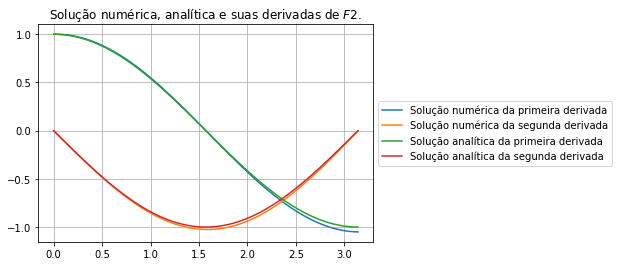

In [ ]:
# Por Euler
# ---------
ts, ys = euler(F2, 0, np.pi, np.array([1.0,0.0]), nsteps=100)
vs = np.transpose(ys)

# Analítica
# ---------
ans = np.array([-1.0505597866729235, -0.0010851561020816455])

# Gráfico
# -------
plt.plot(ts, vs[0], label = "Solução numérica da primeira derivada")
plt.plot(ts, vs[1], label = "Solução numérica da segunda derivada")
plt.plot(ts, np.cos(ts), label = "Solução analítica da primeira derivada")
plt.plot(ts, -np.sin(ts), label = "Solução analítica da segunda derivada")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Solução numérica, analítica e suas derivadas de $F2$.')
ax = plt.gca()
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('')
plt.grid()
plt.show();

In [ ]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 4
assert len(ax.legend().texts) == 4

In [ ]:
xdata = ax.lines[0].get_xdata()
assert min(xdata) == 0.0
assert max(xdata) == np.pi

ydata = [l.get_ydata() for l in ax.lines]
assert -1.1 < np.min(ydata) < -1.0
assert np.max(ydata) == 1.0

In [ ]:
ax = None

Agora, aumente o intervalo de integração para $6\pi$, e use 600 passos.

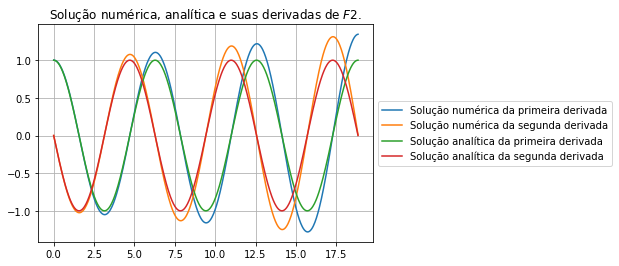

In [ ]:
# Por Euler
# ---------
ts, ys = euler(F2, 0, 6*np.pi, np.array([1.0,0.0]), nsteps=600)
vs = np.transpose(ys)

# Analítica
# ---------
ans = np.array([-1.0505597866729235, -0.0010851561020816455])

# Gráfico
# -------
plt.plot(ts, vs[0], label = "Solução numérica da primeira derivada")
plt.plot(ts, vs[1], label = "Solução numérica da segunda derivada")
plt.plot(ts, np.cos(ts), label = "Solução analítica da primeira derivada")
plt.plot(ts, -np.sin(ts), label = "Solução analítica da segunda derivada")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Solução numérica, analítica e suas derivadas de $F2$.')
ax = plt.gca()
ax.set_xlabel('')
ax.set_ylabel('')
plt.grid()
plt.show();

O que aconteceu?

Apesar do aumento, em mesma proporção, de ambos o número de passos e intervalo de integração, o erro evidentemente cresce, o que, muito naturalmente, sugere que o mesmo aumente mais rapidamente, com o aumento do intervalo, do que o ganho em precisão, ao se aumentar o número de passos. Isso, por sua vez, sugere que o método seja mais interessante quando aplicado a análises numéricas mais locais.

### 6. Erros multidimensionais

Voltemos ao intervalo $[0, \pi]$.
Como se comporta o erro no caso do sistema acima, conforme o número de pontos aumenta?
Qual erro é mais importante: o da derivada ($f_2$) ou o da função original ($f_1$)?
Você vê uma razão para isso?

In [ ]:
%%time
ns = np.logspace(1,5,num=21, dtype=int)

# Erro de f1 e f2
# ---------
errosf1 = []
errosf2 = []
errosf1n = []
errosf2n = []
tss = []
nss = []
for n in ns:
  ts, ys = euler(F2, 0, np.pi, np.array([1.0,0.0]), nsteps=n)
  vs = np.transpose(ys)
  for t in ts:
    errosf1n.append(abs(vs[0] - np.cos(ts)))
    errosf2n.append(abs(vs[1] + np.sin(ts)))
  errosf1.append(errosf1n)
  errosf2.append(errosf2n)
  tss.append(ts)
  nss.append([n]*len(ts))

# Gráfico
# -------
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
plt.scatter(nss, errosf1, tss, label = "Erro de f1")
plt.scatter(nss, errosf2, tss, label = "Erro de f2")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Erro de $F2$ e da sua derivada para diferentes passos')
plt.show()
plt.grid()

KeyboardInterrupt: ignored

In [ ]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 2
assert len(ax.legend().texts) == 2

In [ ]:
xdata = ax.lines[0].get_xdata()
assert min(xdata) == 1e1
assert max(xdata) == 1e5

ydata = [l.get_ydata() for l in ax.lines]
assert 1e-5 < np.min(ydata) < 5e-5
assert 1e-1 < np.max(ydata) < 5e-1

AssertionError: ignored

Comente abaixo

YOUR ANSWER HERE

O erro certamente depende do intervalo "de integração" da equação diferencial.
Será que a importância relativa também depende? Faça o gráfico do erro para o intervalo $[0, \pi/2]$ e conclua.

In [ ]:
%%time
ns = np.logspace(1,5,num=21, dtype=int)
# YOUR CODE HERE
raise NotImplementedError()

Comente

YOUR ANSWER HERE

## Parte 2: Métodos de maior ordem para EDOs

### Equações diferenciais e Integrais

Calcular a integral $\int_a^b h(t) \, dt$ é a mesma coisa que resolver a equação diferencial
$$ \begin{cases}
  y'(t) & = h(t) \\
  f(a)  & = 0,
\end{cases} $$
pelo Teorema Fundamental do Cálculo.
Portanto, é possível implementar uma função `int_rect` usando a função `euler`.

Isso é verdade para vários métodos de integração: muitas vezes existe um método de Equações Diferenciais cujo caso particular é um método de integração quando a ED é "trivial"
(ou seja, quando a fórmula $F$ para $y'(t)$ não depende de $y(t)$).

### O método do Trapézio para EDOs: uma equação implícita

Inversamente, podemos usar métodos de integração e "generalizar" para usar em EDOs.
Por exemplo, podemos usar a aproximação do trapézio:
$$ y(h) = y(0) + \int_0^h y'(t) \, dt \sim h \cdot \frac{y'(0) + y'(h)}{2}.$$

Substituindo a EDO $f'(t) = F(t, f(t))$, isto dá uma equação **implícita** para calcular $y(h)$.

### Trapézio 1: Equação implícita

Escreva a equação implícita que a aproximação $y_1$ de $y(h)$ satisfaz, em função de $y_0$, $h$, $F$, $\ldots$.

$$
y_1 \approx 
$$

### Trapézio 2: resolvendo a equação implícita de 1 passo

Escreva uma função que dá o passo do método do trapézio.

Obs: O método da secante precisa de dois pontos para iniciar.
Que valor de $y$ deve estar próximo à solução?
Se você tiver que "chutar" outro valor, este provavelmente estará mais próximo ou mais distante?
Qual deles você deve usar como primeiro e qual como segundo valor na secante?

In [ ]:
# Inclua aqui seu código da secante
def secante(F, t0, y0, h=1e-6, maxiter=10000):
    """ Método da secante para a função  F  no intervalo  [t0,y0].

        Retorna um número  z. O algoritmo para quando o último passo é menor do 
        que  h, ou depois de  maxiter  iterações.
    """
    def passo_secante(F, t0, t1, y): 
        """Dada a função  F, e o intervalo  [t0,y0], aplica um passo do método da secante."""
        F0, F1 = F(t0,y0), F(t0+h,y0+h) # Declaração de variaveis auxiliares
        return (y0*F1 - t0*F0)/(F1 - F0)
    
    # Estrutura iterativa
    num_iter = 0 # Inicializamos a var
    while True:
        z = passo_secante(F, t0, y0)
        num_iter += 1

        # Se podemos parar, paramos
        if abs(z - y0) < h or num_iter == maxiter: return z

        # Se não, atualizamos as extremidades do intervalo
        t0, y0 = y0, z

In [ ]:
def trapezoidal_step_sec(F, tcurr, ycurr, h) -> float:
    """Resolve a equação implícita do método trapezoidal pelo método da secante, partindo de (tcurr,ycurr),
    retornando uma aproximação de  y  em  tcurr+h."""
    tnext = tcurr+h
    raiz = secante(F, tcurr, ycurr, h)
    return F(tnext, raiz)

### Alguns testes simples

In [ ]:
def G(t,y):
    return t - np.cos(y)

ynext = trapezoidal_step_sec(G, 0, 1, 0.1)
assert abs(ynext - 0.9488541465905801) < 1e-14

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in cos
  


AssertionError: ignored

In [ ]:
ynext = trapezoidal_step_sec(G, 0, 1, 0.3)
assert abs(ynext - 0.8668725901552984) < 1e-14

TypeError: ignored

### Trapézio 3: Resolvendo a EDO

Agora, incorporamos o passo do trapézio numa função `trapezoidal_ode`, análoga à `euler`,
que resolve a EDO $y' = F(t, y(t))$ pelo método do trapézio.

In [ ]:
def trapezoidal_ode(F, t0, tf, y0, nsteps=100):
    """Calcula uma solução aproximada da equação  y' = F(t,y)  pelo método do trapézio,
    dividindo o intervalo  [t0, tf]  em  nsteps  passos,
    e usando o método da secante para resolver a equação implícita."""
    # YOUR CODE HERE
    raise NotImplementedError()
    return ts, np.array(ys)

In [ ]:
def F1(t,y):
    return y

t_100, y_100 = trapezoidal_ode(F1, 0, 1, 1)
assert len(t_100) == 101
assert t_100[0] == 0
assert t_100[-1] == 1

In [ ]:
t_100, y_100 = trapezoidal_ode(F1, 0, 1, 1)
assert len(y_100) == 101
assert y_100[0] == 1
assert( abs(y_100[-1] - 2.7183044812417965) < 5e-15 )

In [ ]:
def F_dificil(t, y):
    return t*np.sin(y) - t**2*np.cos(y)

_, y_dificil = trapezoidal_ode(F_dificil, 0, 2, 1, nsteps=100)
assert( abs(y_dificil[-1] - 3.587544094834753) < 5e-15 )

In [ ]:
t_100, y_100 = trapezoidal_ode(F1, 0, 1, 1)
assert np.allclose(y_100, np.exp(t_100))
assert 1e-5 < np.max(y_100 - np.exp(t_100)) < 5e-5

t_1000, y_1000 = trapezoidal_ode(F1, 0, 1, 1, nsteps=1000)
assert np.allclose(y_1000, np.exp(t_1000), rtol=1e-7)
assert 1e-7 < np.max(y_1000 - np.exp(t_1000)) < 5e-7

O que a caixa acima está testando?

YOUR ANSWER HERE

### O método do ponto médio para integrais

Esse é um método de "duplo cálculo", e explícito:

- Andamos metade do tempo $h$, usando um passo "de Euler"
- Recalculamos o passo de Euler, mas usamos a derivada "no meio do caminho",
  que é uma aproximação melhor (porque simétrica).

Em fórmulas:
- Passo explícito, $m_i = y_i + F(t_i, y_i) \cdot h/2$
- 2º passo explícito: $y_{i+1} = y_i + F(t_i + h/2, m_i) \cdot h$

### Ponto médio 1:

Escreva uma função que dá o novo ponto usando a regra do ponto médio

In [ ]:
def midpoint_step(F, t, y, h=1e-6) -> float:
    """Calcula um passo do método do ponto médio.
    """
    m = y + F(t,y) * h/2
    novo_y = y + F(t + h/2, m) * h
    return novo_y

In [ ]:
def G(t,y):
    return t - np.cos(y)

ynext = midpoint_step(G, 0, 1, 0.1)
assert abs(ynext - 0.9487165172210511) < 1e-14

In [ ]:
ynext = midpoint_step(G, 0, 1, 0.3)
assert abs(ynext - 0.8630045486909678) < 1e-14

### Ponto médio 2: EDO

E agora, incorpore este passo num método de resolução de EDOs

In [35]:
def midpoint_ode(F, t0, tf, y0, nsteps=100):
    """Calcula uma solução aproximada da equação y' = F(t,y) no intervalo  [t0, tf]  usando  nsteps  passos,
    usando o passo explícito no ponto médio."""
    assert nsteps > 0
    ts, ys = np.linspace(t0, tf, num=nsteps+1, endpoint=True), [y0]
    
    h = (tf - t0) / nsteps
    ycurr = y0
    for t in ts[1:]:
        ynext = midpoint_step(F, t, ycurr, h)
        ycurr = ynext
        ys.append(ycurr)

    return ts, np.array(ys)

In [32]:
def F1(t,y):
    return y

t_100, y_100 = midpoint_ode(F1, 0, 1, 1)
assert len(t_100) == 101
assert t_100[0] == 0
assert t_100[-1] == 1

In [36]:
t_100, y_100 = midpoint_ode(F1, 0, 1, 1)
assert len(y_100) == 101
assert y_100[0] == 1
assert( abs(y_100[-1] - 2.718236862559957) < 5e-15 )

In [37]:
def F_dificil(t, y):
    return t*np.sin(y) - t**2*np.cos(y)

_, y_dificil = midpoint_ode(F_dificil, 0, 2, 1, nsteps=100)
assert( abs(y_dificil[-1] - 3.5874427140529868) < 5e-15 )

AssertionError: ignored

In [ ]:
t_100, y_100 = midpoint_ode(F1, 0, 1, 1)
assert np.allclose(y_100, np.exp(t_100), rtol=2e-5)
assert 2e-5 < np.max(abs(y_100 - np.exp(t_100))) < 10e-5

t_1000, y_1000 = midpoint_ode(F1, 0, 1, 1, nsteps=1000)
assert np.allclose(y_1000, np.exp(t_1000), rtol=2e-7)
assert 2e-7 < np.max(abs(y_1000 - np.exp(t_1000))) < 10e-7

### Gráficos

### Gráficos 1: Solução de EDOs

Resolva a EDO

$$y' = t - \cos(y)$$

com condição inicial $y(0) = 1$ no intervalo $[0,5]$, usando 30 pontos,
pelos 3 métodos (Euler, Trapézio, ponto médio).
Faça o gráfico das três soluções.
Não esqueça do título e da legenda!

In [ ]:
# Definimos a EDO
# ---------------
def F(t, y):
    return t - np.cos(y)

# Infos dadas
# -----------
y0 = 1
t0, tf = 0, 5
npts = 30

# Ao plot
# ----------------
methods = [euler, trapezoidal_ode, midpoint_ode]
for m in methods:
    ts, ys = m(F, t0, tf, y0, nsteps)
    plt.plot(ts, ys, label=m.__name__)

plt.grid()
plt.legend(title="Solução de $y'=t-\cos(y)$ por diferentes métodos numéricos.")
ax = plt.gca()
ax.set_xlabel('ts')
ax.set_ylabel('ys')
plt.show()

NameError: ignored

In [ ]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 3
assert len(ax.legend().texts) == 3

In [ ]:
ax = None

Esta EDO não tem "solução analítica simples".
Como você faria para saber qual das curvas está "mais correta"?
Explique sua ideia abaixo, e faça contas / gráficos na caixa seguinte

Podemos testar valores ao longo da curva para ver o quão próxima ela está da definição da função. Isto é, fazemos $y'(t)=t-\cos(y(t))$ e vemos se o respectivo ponto no gráfico está suficientemente próximo.

In [ ]:
def y_linha(t, y):
    return t - cos(y)

y_linha = np.vectorize(y_linha)

methods = [euler, trapezoidal_ode, midpoint_ode]
for m in methods:
    print(f'\n{m.__name__}\n{'-'*len(m.__name__)}')
    ts, ys = m(F, t0, tf, y0, nsteps)
    dists = ys - y_linha(ts, ys)
    print(f'Média das distâncias   -> {np.mean(dists)}')
    print(f'Desvio padrão das dist.-> {np.std(dists)}')
    print(f'Dispersão das dist.    -> {np.max(dists) - np.min(dists)}')

print(max_dist) 

### Gráficos 2: Velocidade de convergência

In [ ]:
methods_3 = [euler, trapezoidal_ode, midpoint_ode]

NameError: ignored

Faça uma função que desenha o gráfico dos erros de solução de uma EDO, dados
- a função $F$ da EDO
- o intervalo $[a,b]$
- a condição inicial $y_0$
- a solução analítica `ysol`
- o número de pontos $n$


In [ ]:
def graph_err(F, a,b, y0, ysol, n, methods=methods_3):
    """Desenha os gráficos dos erros de solução de uma EDO"""
    for m in methods:
        ts, ys = m(F, t0, tf, y0, n)
        err = erro(ysol, ys, ts)
        plt.plot(ts, err, label=m.__name__)
    plt.gca().set_xlabel(f'ts')
    plt.gca().set_ylabel('Erro absoluto')
    plt.legend(title="Método")
    plt.grid()

NameError: ignored

Uma EDO conhecida, para comparar o erro: $$y' = -y.$$

In [ ]:
def G2(t,y): return -y
def ysol2(t): return np.exp(-t)

graph_err(G2, 0,2, 1, ysol2, 30)
plt.yscale('symlog', linthresh=1e-4) # Com "symlog", não use valores absolutos
plt.grid()
ax = plt.gca()

In [ ]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 3
assert len(ax.legend().texts) == 3

In [ ]:
xdata = ax.lines[0].get_xdata()
assert min(xdata) == 0.0
assert max(xdata) == 2.0

ydata = [l.get_ydata() for l in ax.lines]
assert -2e-2 < np.min(ydata) < -1e-2
assert  1e-4 < np.max(ydata) <  4e-4

### Gráficos 3: Erro em função de $n$

Usando a função `erro` definida anteriormente, faça o gráfico do erro, para os 3 métodos,
em função de $n$, para a EDO $y' = y$, no intervalo $[0,2]$.

In [ ]:
%%time
ns = np.logspace(1,5,num=21, dtype=int)

methods = [euler, trapezoidal_ode, midpoint_ode]
for m in methods:
    err_array = []
    for n in ns:
        ts, ys = m(F, t0, tf, y0, ns)
        err = erro(ysol2, ys, ts)
        err_array.append(err)
    plt.plot(ns, err_array, label=m.__name__)

plt.grid()
plt.legend(title="Solução de $y'=y$ por diferentes métodos numéricos.")
ax = plt.gca()
ax.set_xlabel('ns')
ax.set_ylabel('Erro absoluto')
plt.show()

In [ ]:
assert ax.title.get_text() != ""
assert len(ax.lines) == 3
assert len(ax.legend().texts) == 3

O que você observa?

YOUR ANSWER HERE